# NBA 2k Linear Regression Model for Player Rating
Huge thanks to Kostiantyn Isaienkov on Kaggle for the inspiration and the data!

link to their profile:
https://www.kaggle.com/datasets/isaienkov/nba2k20-player-dataset

## Goal

I want to fit a linear regression model by first selecting a good set of predictors using stepwise feature selection, then training my model using a 70/30 train/test split to determine if the model is a good predictor of overall player rating. 

In [71]:
# import our packages
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

# Load our data
df = pd.read_csv("nba2k-full.csv")

# view the first 5 rows
df.head()

,full_name,rating,jersey,team,position,b_day,height,weight,salary,country,draft_year,draft_round,draft_peak,college,version
0,LeBron James,97,#23,Los Angeles Lakers,F,12/30/84,6-9 / 2.06,250 lbs. / 113.4 kg.,$37436858,USA,2003,1,1,NaN,NBA2k20
1,Kawhi Leonard,97,#2,Los Angeles Clippers,F,06/29/91,6-7 / 2.01,225 lbs. / 102.1 kg.,$32742000,USA,2011,1,15,San Diego State,NBA2k20
2,Giannis Antetokounmpo,96,#34,Milwaukee Bucks,F-G,12/06/94,6-11 / 2.11,242 lbs. / 109.8 kg.,$25842697,Greece,2013,1,15,NaN,NBA2k20
3,Kevin Durant,96,#7,Brooklyn Nets,F,09/29/88,6-10 / 2.08,230 lbs. / 104.3 kg.,$37199000,USA,2007,1,2,Texas,NBA2k20
4,James Harden,96,#13,Houston Rockets,G,08/26/89,6-5 / 1.96,220 lbs. / 99.8 kg.,$38199000,USA,2009,1,3,Arizona State,NBA2k20


In [72]:
# Descriptive statistics
df.describe()

,rating,draft_year
count,464.000000,464.000000
mean,77.568966,2013.892241
std,6.933780,3.997465
min,67.000000,2001.000000
25%,73.000000,2011.000000
50%,76.000000,2015.000000
75%,80.000000,2017.000000
max,97.000000,2019.000000


In [73]:
df.isnull().sum()

full_name       0
rating          0
jersey          0
team           23
position        0
b_day           0
height          0
weight          0
salary          0
country         0
draft_year      0
draft_round     0
draft_peak      0
college        76
version         0
dtype: int64

In [ ]:
#We want our model to make sense of all th numerical values on a scale that makes sense.

# convert height in feet to centimeters
df["height_cm"] = df["height"].apply(lambda x: float(x.split("/")[-1]) * 100 if "/" in x else np.nan)

# converts to labs
df["weight_lbs"] = df["weight"].apply(lambda x: float(x.split(" ")[0]) if " " in x else np.nan)

# remove $
df["salary_usd"] = df["salary"].str.replace("$", "").str.replace(",", "").astype(float)

# Fill nas to categorical and numeric columns.
numeric_cols = ["draft_year", "height_cm", "weight_lbs", "salary_usd"]
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

categorical_cols = ["team", "position", "country", "draft_round", "draft_peak", "college"]
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])


In [ ]:
# define our target and predictors.
X = df[["team", "position", "country", "draft_year", "draft_round", "draft_peak",
        "college", "height_cm", "weight_lbs", "salary_usd"]]
y = df["rating"]

# we want to "encode" our categorical variables.
categorical_features = ["team", "position", "country", "draft_round", "draft_peak", "college"]
numeric_features = ["draft_year", "height_cm", "weight_lbs", "salary_usd"]



In [ ]:
# encode
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features),
    ]
)

# Build and train our model.
model = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['team', 'position',
                                                   'country', 'draft_round',
                                                   'draft_peak', 'college']),
                                                 ('num', 'passthrough',
                                                  ['draft_year', 'height_cm',
                                                   'weight_lbs',
                                                   'salary_usd'])])),
                ('regressor', LinearRegression())])

In [ ]:
# calculate accuracy
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f"Model R² Score: {r2:.3f}")

Model R² Score: 0.695


In [ ]:
# therefore 69.5% of the variance in y (rating) is explained by our selected predictors.
# This is not too bad considering the simplicity of the model
# Would be better to train test over a larger data set obviously but I'm pretty happy with this!

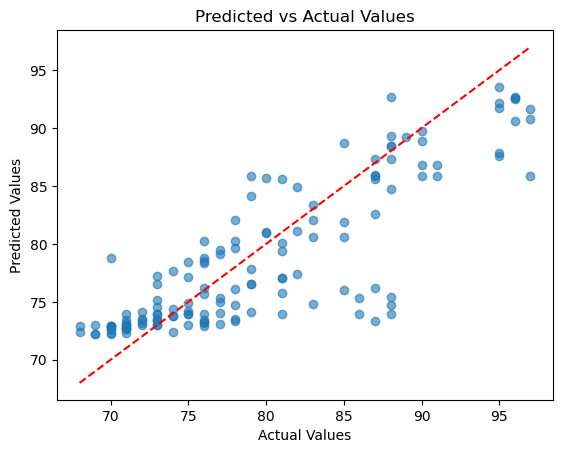

In [ ]:
# Lets visualize our model
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()


In [ ]:
#Lets compute a 95 percent condifence interval for R^2

r = np.corrcoef(y_test, y_pred)[0, 1]
n = len(y_test)

z = np.arctanh(r)
se = 1 / np.sqrt(n - 3)

z_crit = 1.96
z_lower = z - z_crit * se
z_upper = z + z_crit * se

r_lower = np.tanh(z_lower)
r_upper = np.tanh(z_upper)

R2_lower = r_lower**2
R2_upper = r_upper**2

print(f"R²: {r**2:.3f}, 95% CI: [{R2_lower:.3f}, {R2_upper:.3f}]")


R²: 0.710, 95% CI: [0.619, 0.783]


## Conclusion
Overall, the model provides a reliable baseline for rating predictions, and further improvements could be achieved by incorporating additional player statistics, or exploring more complex models. These results suggest the approach is effective, yet there remains room to refine predictions and capture subtler patterns in the data.